#SUPERVISED LEARNING




##Exam project 1 


*   Davide Zangari 844760
*   Martin Joel Mouk Elele 896659


**Image classification using SIFT/Bag of words coupled with traditional classifiers and CNNs**

*no plagiarized content or code copied from other sources, including ChatGPT or similar, has been used in the following notebook.*

In [ ]:
from google.colab import drive
drive.mount('/content/drive') # mounting the google drive

Mounted at /content/drive


# ***TASK 1***

> Data Preprocessing: preprocess the images by resizing them to a common size, converting them to
grayscale or RGB, and normalizing the pixel values.



In [ ]:
# import some useful libraries
import glob 
import cv2
from PIL import ImageOps
import numpy as np
from PIL import Image
import numpy as np
import os
import pandas as pd
import torch

# training on GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if train_on_gpu else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


In [ ]:
# Extract the files from the .zip
from zipfile import ZipFile
with ZipFile("/content/drive/MyDrive/Master degree AI/Supervised Learning/TinyImageNet.zip", 'r') as zObject:
  zObject.extractall(path = "/content/") # Extract the zip
zObject.close() # Close the zip
train_path = "/content/TinyImageNet/train" 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import cv2

# Extract the descriptors from the file
def extract_sift_features(image_path):
    image = cv2.imread(image_path) # Read the image
    if image is None: # If the image is not loaded
        print(f"Failed to load image: {image_path}") # Print the error
        return None
    image = cv2.resize(image, (64, 64)) # Resize the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert to grayscal
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8') # normalisation
    sift = cv2.xfeatures2d.SIFT_create() # Create the SIFT 
    keypoints, descriptors = sift.detectAndCompute(image, None) # Detect and compute the keypoints
    if descriptors is not None and len(descriptors) > 0: # If the keypoints are detected
        return descriptors[0]  # Return the first descriptor
    else:
        return None # If no keypoints are detected

# Extract SIFT features, labels and paths from the file
def extract_features_from_file(file_path): # Extract SIFT features and labels
    image_paths = [] # List of image paths
    labels = [] # List of labels
    features = [] # List of descriptors
    keys = []

    with open(file_path, 'r') as file: # Open the file
        for line in file: # Read each line
            line = line.strip()  # Remove the newline
            image_path, label = line.split(' ')  # Split the line
            image_path = os.path.join('/content/TinyImageNet/', image_path)  # Join the path
            image_paths.append(image_path)  # Append the image path
            labels.append(int(label))  # Convert the label to an integer
            descriptor = extract_sift_features(image_path)  # Extract the SIFT features
            if descriptor is not None: 
                features.append(descriptor)  # Append the descriptor to the features list
            else:
                #print(f"Cannot extract the features from the image: {image_path}. Removing the image and its label.")
                del image_paths[-1]  # removing the last image
                del labels[-1]  # removing the last label
    return np.array(features), np.array(labels), image_paths # Return the features and labels

# **TASK 2**

> Feature Extraction using SIFT and Bag of Words: extract features from the images using ScaleInvariant Feature Transform (SIFT) (or similar approaches) and Bag of Words (BoW) representation and train a traditional
classifier (e.g., Support Vector Machines (SVMs), Random Forests, or k-Nearest Neighbors (k-NN)) to classify them.

### ScaleInvariant Feature Transform (SIFT)

In [ ]:
# dataloader
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
import scipy 
import torch 

class TinyDataset(Dataset):

# Define the constructor
    def __init__(self, image_path, labels, transform = None):
        self.image_path = image_path # List of image paths
        self.labels = labels # List of labels
        self.transform=transform # Transformations

# Define the getitem function
    def __getitem__(self, idx):
        image = cv2.imread(self.image_path[idx]) # Read the image
        image = cv2.resize(image, (64, 64)) # Resize the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert to grayscal
        image = np.array(image, dtype=np.float32) / 255.0 # Normalisation
        image = torch.tensor(image).unsqueeze(0) # Convert to tensor
        label = self.labels[idx] # Get the label
        label = torch.tensor(label).unsqueeze(0) # Convert to tensor

        if self.transform: 
            image = self.transform(image) # Apply the transformations

        return image, label # Return the image and its label

# Define the length function
    def __len__(self):
        return len(self.labels) # Return the length of the dataset

In [ ]:
# Set the paths
sift_image_list_file = '/content/TinyImageNet/train.txt'  # Update with your image list file path

# Extract SIFT features and labels from the file
sift_features, sift_labels, sift_image_paths = extract_features_from_file(sift_image_list_file)

In [ ]:
sift_features

array([[100.,  42.,   0., ...,  35.,   0.,   0.],
       [  0.,   0.,   0., ...,  15.,  57.,  99.],
       [  4.,  13.,  57., ...,   0.,   0.,   0.],
       ...,
       [  1.,   0.,   0., ...,   0.,   0.,   8.],
       [ 39.,   9.,   0., ...,   0.,   0.,   6.],
       [  1.,   4.,   4., ...,   0.,   0.,   0.]], dtype=float32)

In [ ]:
sift_labels.shape # checking whether the no. of labels is consisent

(99955,)

In [ ]:
sift_features.shape

(99955, 128)

### Bag of Words (BoW)

In [ ]:
# Convert SIFT features to BoW features
bow_features = [] # initialising a list of BoW features
n_clusters = 100 # number of clusters of the BoW (dictionary size)
kmeans = KMeans(n_clusters=n_clusters) # Initialise the KMeans
kmeans.fit(sift_features) # Fit the KMeans

for sift_desc in sift_features: # For each descriptor
    bow_feature = np.zeros((n_clusters,), dtype=np.float32) # Initialise the BoW feature
    sift_desc_reshape = sift_desc.reshape(-1, 128)  # Reshape sift_desc to have shape (n_samples, n_features)
    cluster_indices = kmeans.predict(sift_desc_reshape) # Get the cluster indices
    for cluster_idx in cluster_indices: # For each cluster
        bow_feature[cluster_idx] += 1 # Increment the BoW
    bow_features.append(bow_feature) # Append the BoW feature to the list of BoW features

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Split the dataset into training and testing sets
train_bow_features, test_bow_features, train_labels, test_labels = train_test_split(bow_features, sift_labels, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

knn_param_grid = {'n_neighbors':  [5, 15, 50, 300, 999]} # Define the parameter grid for KNN

# Create the KNN classifier
knn = KNeighborsClassifier()
knn_grid_search = GridSearchCV(knn, knn_param_grid, cv=5) # Create the GridSearchCV object for KNN
knn_grid_search.fit(train_bow_features, train_labels) # Perform the grid search for KNN
best_k = knn_grid_search.best_params_['n_neighbors'] # Get the best parameter value for KNN
knn = KNeighborsClassifier(n_neighbors = best_k) # Train the KNN classifier with the best k
knn.fit(train_bow_features, train_labels)
knn_accuracy = knn.score(test_bow_features, test_labels) # Evaluate the KNN classifier on the test set
rf_param_grid = {'n_estimators': [5, 15, 50, 100]} # Define the parameter grid for Random Forest

# Create the Random Forest classifier
rf = RandomForestClassifier()
rf_grid_search = GridSearchCV(rf, rf_param_grid, cv = 5) # Create the GridSearchCV object for Random Forest
rf_grid_search.fit(train_bow_features, train_labels) # Perform the grid search for Random Forest
best_n_estimators = rf_grid_search.best_params_['n_estimators'] # Get the best parameter value for Random Forest

rf = RandomForestClassifier(n_estimators=best_n_estimators) # Train the Random Forest classifier with the best number of estimators
rf.fit(train_bow_features, train_labels)
rf_accuracy = rf.score(test_bow_features, test_labels) # Evaluate the Random Forest classifier on the test set

print("Best k for KNN:", best_k) # Print the best k
print("KNN Accuracy:", knn_accuracy) # Print the KNN accuracy

print("Best number of estimators for Random Forest:", best_n_estimators) # Print the best number of estimators
print("Random Forest Accuracy:", rf_accuracy) # Print the Random Forest accuracy

Best k for KNN: 999
KNN Accuracy: 0.017808013606122754
Best number of estimators for Random Forest: 50
Random Forest Accuracy: 0.01850832874793657


In [ ]:
pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.017808013606122754
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       199
           1       0.00      0.00      0.00       187
           2       0.00      0.00      0.00       217
           3       0.00      0.00      0.00       196
           4       0.02      0.02      0.02       190
           5       0.02      0.09      0.04       186
           6       0.00      0.00      0.00       220
           7       0.01      0.01      0.01       194
           8       0.01      0.01      0.01       220
           9       0.02      0.02      0.02       191
          10       0.00      0.00      0.00       204
          11       0.01      0.03      0.02       210
          12       0.00      0.00      0.00       211
          13       0.00      0.00      0.00       205
          14       0.00      0.01      0.00       190
          15       0.00      0.00      0.00       199
          16       0.00   

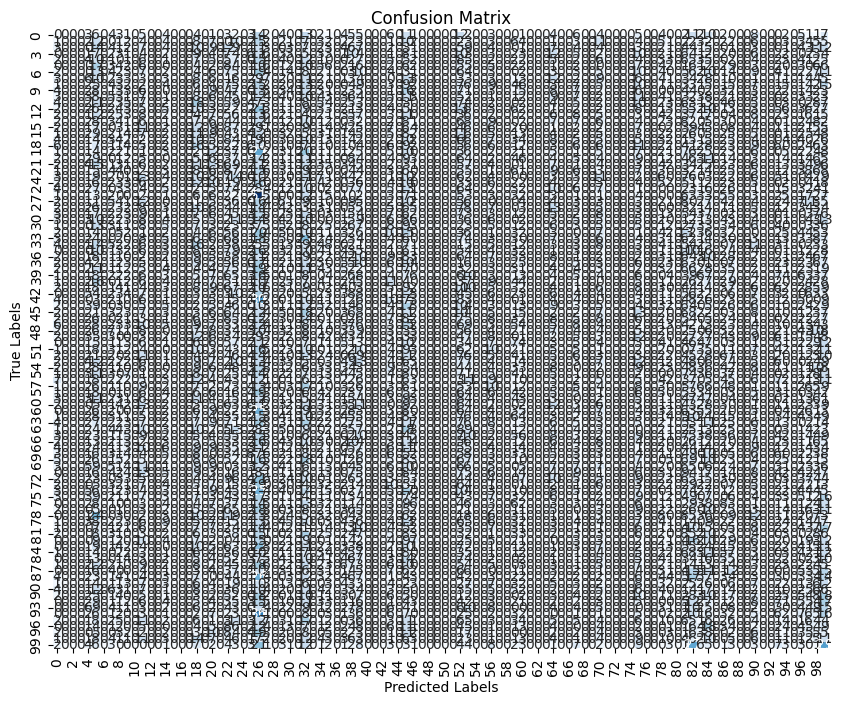

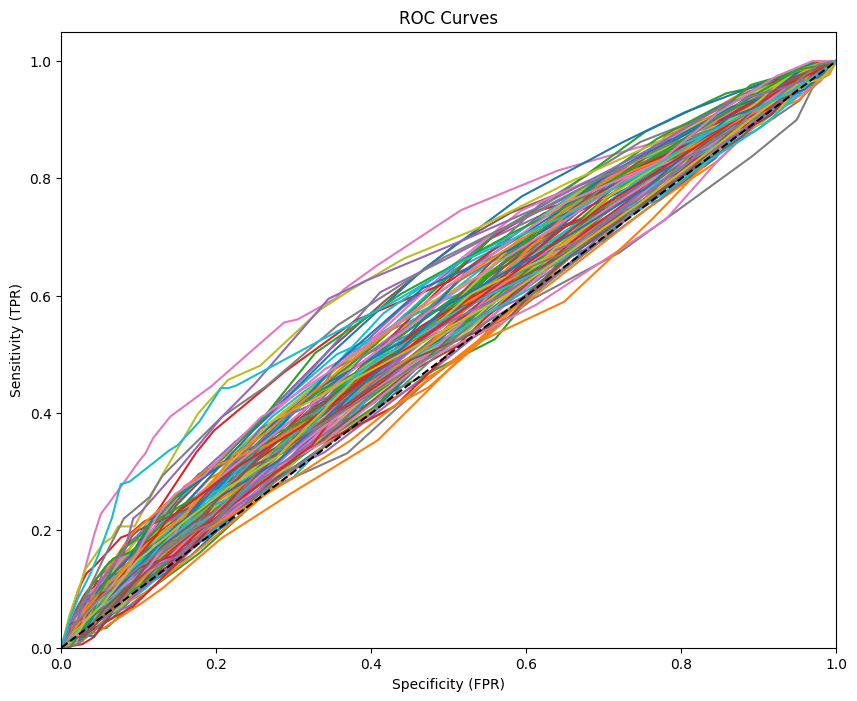

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# KNN - Evaluation
knn_pred = knn.predict(test_bow_features) # Predict the labels
accuracy = knn.score(test_bow_features, test_labels) # Evaluate the KNN classifier
classification_rep = classification_report(test_labels, knn_pred) # Get the classification report
conf_matrix = confusion_matrix(test_labels, knn_pred) # Get the confusion matrix

print("Accuracy:", accuracy) # Print the accuracy
print("Classification Report:\n", classification_rep) # Print the classification report
print("Confusion Matrix:\n", conf_matrix) # Print the confusion matrix

# Plot the confusion matrix as a heatmap
plt.figure(figsize = (10, 8)) # Set the figure size
sns.heatmap(conf_matrix, annot = True, cmap = 'Blues', fmt = 'd', cbar = False) # Plot the confusion matrix
plt.xlabel('Predicted Labels') # Set the x-axis label
plt.ylabel('True Labels') # Set the y-axis label
plt.title('Confusion Matrix') # Set the title
plt.show() # Show the figure plot

# Compute and plot the ROC curves for each class
n_classes = len(np.unique(test_labels)) # Get the number of classes
knn_probs = knn.predict_proba(test_bow_features) # Get the probabilities

plt.figure(figsize=(10, 8)) # Set the figure size
for i in range(n_classes): # For each class
    fpr, tpr, _ = roc_curve(test_labels, knn_probs[:, i], pos_label = i) # Compute the ROC curve
    roc_auc = auc(fpr, tpr) # Compute the area under the ROC
    plt.plot(fpr, tpr, label = f'Class {i} (AUC = {roc_auc:.2f})') # Plot the ROC curve

plt.plot([0, 1], [0, 1], 'k--') # Plot the diagonal
plt.xlim([0.0, 1.0]) # Set the x-axis limits
plt.ylim([0.0, 1.05]) # Set the y-axis limits
plt.xlabel('Specificity (FPR)') # Set the x-axis label
plt.ylabel('Sensitivity (TPR)') # Set the y-axis label
plt.title('ROC Curves') # Set the title
#plt.legend(loc='lower right')
plt.show() # Show the figure plot

# **TASK 3**

>  Convolutional Neural Networks: train a convolutional neural network (CNN) on the preprocessed
images to classify them into different categories. The student should experiment with different architectures such as
VGG, ResNet, Inception, etc.

we have 100 labels, varying from 0 up to 99 after the filename (.jpg)

### transfer learning with resnet50

In [ ]:
# data augmentation on the training to prevent overfitting and increase the generalization power
import pickle 
import torchvision.transforms as transforms

transform_train = transforms.Compose([ # Define the transformations for training set
    transforms.RandomHorizontalFlip(), # Randomly perform horizontal flip the image
    transforms.RandomVerticalFlip(), # Randomly perform vertical flip the image
    #transforms.RandomRotation(10),  # Randomly rotate the image of 10 degrees               
])
dataset = TinyDataset(sift_image_paths, sift_labels) # Define the dataset
dataset.__getitem__(0) # Get the first item of the dataset

(tensor([[[0.4471, 0.4549, 0.4745,  ..., 0.4510, 0.4588, 0.4353],
          [0.4745, 0.4667, 0.4941,  ..., 0.4627, 0.4392, 0.4157],
          [0.5098, 0.5059, 0.5098,  ..., 0.4784, 0.4706, 0.4510],
          ...,
          [0.6157, 0.5765, 0.7294,  ..., 0.9333, 0.9373, 0.9294],
          [0.6314, 0.5843, 0.6196,  ..., 0.8824, 0.9020, 0.9137],
          [0.5529, 0.5647, 0.6588,  ..., 0.8706, 0.8745, 0.8745]]]),
 tensor([0]))

In [ ]:
# splitting the dataset into training and validation sets with a test size of 30%
train_ds, val_ds = train_test_split(dataset, test_size = 0.3, shuffle=True)

In [ ]:
import os
os.cpu_count()

In [ ]:
transformed = TinyDataset(sift_image_paths, sift_labels, transform = transform_train) # Define the transformed dataset
train_ds = torch.utils.data.ConcatDataset([train_ds, transformed]) # Concatenate the two datasets
batch_size = 32 # Define the batch size
train_dl = torch.utils.data.DataLoader(train_ds, batch_size = batch_size, # Create the dataloader
                        shuffle=True, num_workers = os.cpu_count()) # Set the number of workers in my pc (cpu_counts() is 2)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size = batch_size, # Create the dataloader
                        shuffle=False, num_workers = os.cpu_count()) # Set the number of workers

class 77


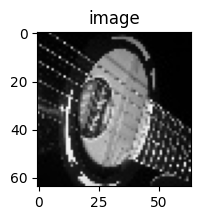

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
import scipy 
import torch 
from zipfile import ZipFile
from PIL import Image as I
import numpy as np
import glob
import os
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2
import random
import matplotlib.pyplot as plt

#reconstruct the image and mask from the dataloader, for inspection
random_index = random.randint(0, len(val_dl.dataset) - 1) # Get a random index
image, label = val_dl.dataset[random_index] # Get the image and label
image = image.unsqueeze(0) # Add a batch dimension
image_np = image.squeeze() # Convert the tensor to a numpy array
label_np = label.squeeze() # Convert the tensor to a numpy array
print('class', int(label)) # Print the label
#print('class', label.item())
plt.figure(figsize = (2, 2)) # Set the figure size
plt.imshow(image_np, cmap = 'gray') # Plot the image
plt.title('image') # Set the title
plt.show() # Show the figure plot

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import random

In [ ]:
model = models.resnet50(pretrained = True) # Load the ResNet-50 model
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias = False) # Modify the first layer to accept single-channel images
num_classes = 100  # Modify the classifier layer to match the number of classes in the dataset
model.fc = torch.nn.Linear(2048, num_classes) # Modify the fully connected layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set the device
model = model.to(device) # Move the model to the device

criterion = nn.CrossEntropyLoss() # Define the loss function: cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001) # Define the optimizer: adam

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 323MB/s]


Epoch 1/20
Training Loss: 3.8811 | Training Accuracy: 0.1100
Validation Loss: 3.5510 | Validation Accuracy: 0.1679

Epoch 2/20
Training Loss: 3.1142 | Training Accuracy: 0.2391
Validation Loss: 3.1964 | Validation Accuracy: 0.2355

Epoch 3/20
Training Loss: 2.7111 | Training Accuracy: 0.3199
Validation Loss: 2.8401 | Validation Accuracy: 0.3055

Epoch 4/20
Training Loss: 2.4106 | Training Accuracy: 0.3834
Validation Loss: 2.8597 | Validation Accuracy: 0.3123

Epoch 5/20
Training Loss: 2.1431 | Training Accuracy: 0.4429
Validation Loss: 2.8736 | Validation Accuracy: 0.3281

Epoch 6/20
Training Loss: 1.9001 | Training Accuracy: 0.4990
Validation Loss: 2.3264 | Validation Accuracy: 0.4142

Epoch 7/20
Training Loss: 1.6671 | Training Accuracy: 0.5542
Validation Loss: 2.0483 | Validation Accuracy: 0.4810

Epoch 8/20
Training Loss: 1.4533 | Training Accuracy: 0.6103
Validation Loss: 1.8281 | Validation Accuracy: 0.5237

Epoch 9/20
Training Loss: 1.2566 | Training Accuracy: 0.6608
Validation 

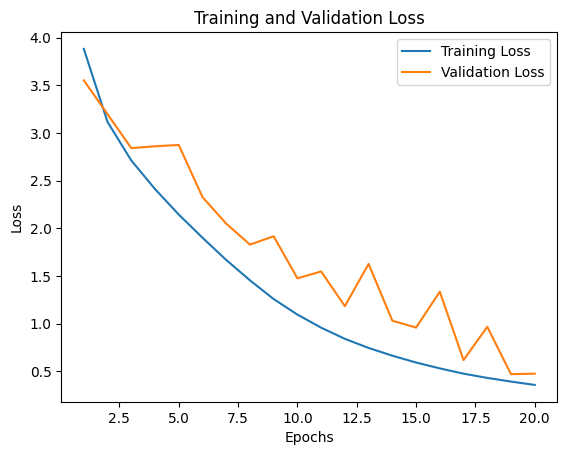

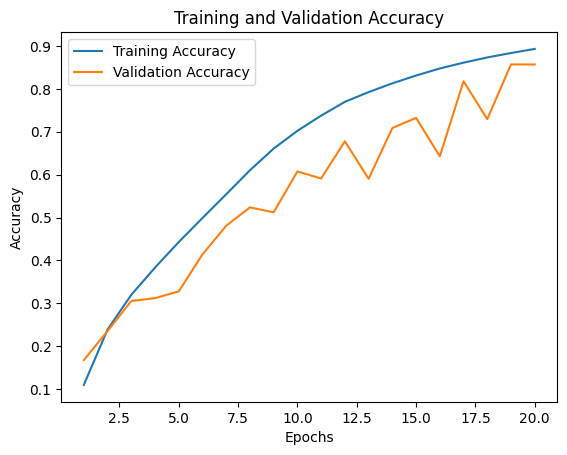

In [ ]:
# Training history
train_losses = []
train_accuracies = []

# Validation history
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 20 # Define the number of epochs

for epoch in range(num_epochs): # For each epoch
    model.train()  # Set the model in training mode
    running_loss = 0.0 # Set the running loss
    correct = 0 # Set the correct
    total = 0 # Set the total

    for images, labels in train_dl: # For each batch
        images = images.to(device) # Move the image
        labels = labels.to(device) # Move the label

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass

        loss = criterion(outputs, labels.squeeze())  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        running_loss += loss.item() # Add the loss
        _, predicted = outputs.max(1) # Get the predicted label
        total += labels.size(0) # Get the total
        correct += predicted.eq(labels.squeeze()).sum().item() # Get the correct

    train_loss = running_loss / len(train_dl) # Compute the training loss
    train_accuracy = correct / total # Compute the training accuracy

    # Validation loop
    model.eval()  # Set the model in evaluation mode
    val_loss = 0.0 # Set the validation loss
    correct = 0 # Set the correct
    total = 0 # Set the total

    with torch.no_grad(): # Do not track the gradients
        for images, labels in val_dl: # For each batch
            images = images.to(device) # Move the image
            labels = labels.to(device) # Move the label

            outputs = model(images) # Forward pass
            loss = criterion(outputs, labels.squeeze()) # Compute the loss

            val_loss += loss.item() # Add the loss
            _, predicted = outputs.max(1) # Get the predicted label
            total += labels.size(0) # Get the total
            correct += predicted.eq(labels.squeeze()).sum().item() # Get the correct

    val_loss /= len(val_dl) # Compute the validation loss
    val_accuracy = correct / total # Compute the validation accuracy

    # Store the training and validation metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print the training and validation loss and accuracy
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")
    print()

# Plotting the training and validation metrics
epochs = range(1, num_epochs + 1)

# Plotting the loss
plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy
plt.figure()
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

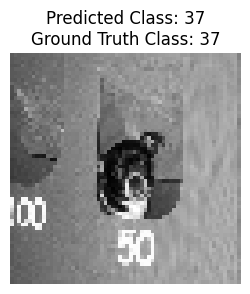

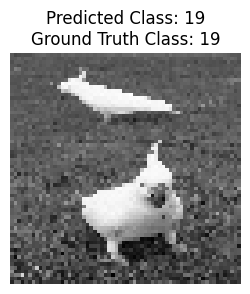

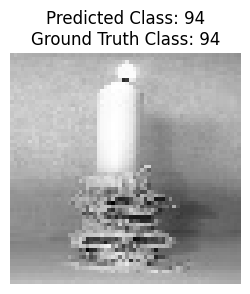

In [ ]:
import random

class_names = [str(i) for i in range(100)] # Define the class names
# Set the model in evaluation mode
model.eval() # Set the model in evaluation mode

for _ in range(3): # 3 images
    random_index = random.randint(0, len(val_ds) - 1) # Select a random image from the validation set
    image, label = val_ds[random_index] # Get the image and label
    image = image.to(device)    # Move the image to the GPU, if available
  
    with torch.no_grad():     # Make a prediction on the image
        output = model(image.unsqueeze(0)) # Forward pass
        predicted_class = torch.argmax(output).item() # Get the predicted class

    predicted_label = class_names[predicted_class] # Get the predicted class label and the real class label
    real_label = class_names[label] # Get the real class label
    image_np = image.cpu().numpy() # Convert the image tensor to numpy array and normalise the values
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min()) # Normalise the image

    # Plot the image with the predicted class and real class
    plt.figure(figsize = (3, 3)) # Set the figure size
    plt.imshow(image_np.squeeze(), cmap = 'gray') # Plot the gray image
    plt.title(f'Predicted Class: {predicted_label}\nGround Truth Class: {real_label}') # Set the title
    plt.axis('off') # Turn off the axis
    plt.show() # Show the figure

### transfer learning with vgg16

In [ ]:
vgg = models.vgg16(pretrained=True) # Load the vgg-16 model
vgg.features[0] = torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1) # Modify the first layer to accept single-channel (grayscale) images
num_classes = 100  # Modify the classifier layer to match the number of classes in the dataset
vgg.classifier[6] = torch.nn.Linear(4096, num_classes) # Modify the last fully connected layer
# Freeze the initial layers of the model (optional)
# for param in vgg.features.parameters():
#     param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set the device
vgg = vgg.to(device) # Move the vgg model to the device

criterion = nn.CrossEntropyLoss() # Define the loss function: cross entropy
optimizer = optim.Adam(vgg.parameters(), lr=0.0001) # Define the optimizer: adam

Epoch 1/20
Training Loss: 1.5295 | Training Accuracy: 0.5995
Validation Loss: 1.6352 | Validation Accuracy: 0.5769

Epoch 2/20
Training Loss: 1.3286 | Training Accuracy: 0.6507
Validation Loss: 1.4988 | Validation Accuracy: 0.6097

Epoch 3/20
Training Loss: 1.1798 | Training Accuracy: 0.6889
Validation Loss: 1.3722 | Validation Accuracy: 0.6446

Epoch 4/20
Training Loss: 1.0661 | Training Accuracy: 0.7202
Validation Loss: 1.2844 | Validation Accuracy: 0.6596

Epoch 5/20
Training Loss: 0.9695 | Training Accuracy: 0.7445
Validation Loss: 1.2527 | Validation Accuracy: 0.6688

Epoch 6/20
Training Loss: 0.8967 | Training Accuracy: 0.7643
Validation Loss: 1.1377 | Validation Accuracy: 0.6974

Epoch 7/20
Training Loss: 0.8350 | Training Accuracy: 0.7806
Validation Loss: 1.1824 | Validation Accuracy: 0.6913

Epoch 8/20
Training Loss: 0.7885 | Training Accuracy: 0.7939
Validation Loss: 1.0852 | Validation Accuracy: 0.7163

Epoch 9/20
Training Loss: 0.7471 | Training Accuracy: 0.8047
Validation 

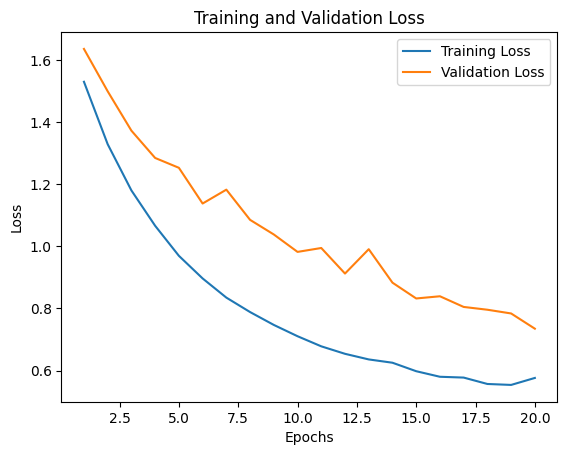

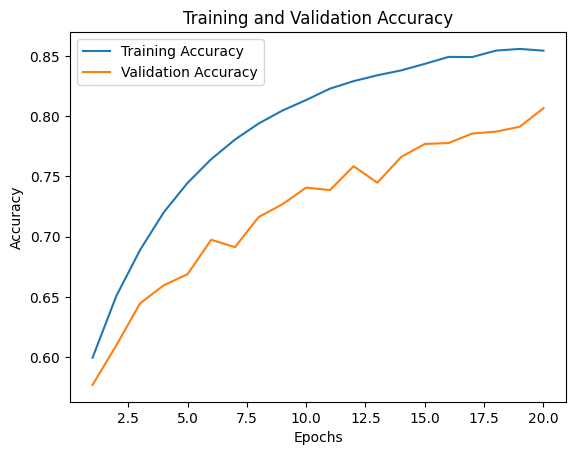

In [ ]:
# Training history
train_losses = []
train_accuracies = []

# Validation history
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 20 # Define the number of epochs

for epoch in range(num_epochs): # For each epoch
    vgg.train()  # Set the model in training mode
    running_loss = 0.0 # Set the running loss
    correct = 0 # Set the correct
    total = 0 # Set the total

    for images, labels in train_dl: # For each batch
        images = images.to(device) # Move the image
        labels = labels.to(device) # Move the label

        optimizer.zero_grad()  # Zero the gradients
        outputs = vgg(images)  # Forward pass

        loss = criterion(outputs, labels.squeeze())  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        running_loss += loss.item() # Add the loss
        _, predicted = outputs.max(1) # Get the predicted label
        total += labels.size(0) # Get the total
        correct += predicted.eq(labels.squeeze()).sum().item() # Get the correct

    train_loss = running_loss / len(train_dl) # Compute the training loss
    train_accuracy = correct / total # Compute the training accuracy

    # Validation loop
    vgg.eval()  # Set the model in evaluation mode
    val_loss = 0.0 # Set the validation loss
    correct = 0 # Set the correct
    total = 0 # Set the total

    with torch.no_grad(): # Do not track the gradients
        for images, labels in val_dl: # For each batch
            images = images.to(device) # Move the image
            labels = labels.to(device) # Move the label

            outputs = vgg(images) # Forward pass
            loss = criterion(outputs, labels.squeeze()) # Compute the loss

            val_loss += loss.item() # Add the loss
            _, predicted = outputs.max(1) # Get the predicted label
            total += labels.size(0) # Get the total
            correct += predicted.eq(labels.squeeze()).sum().item() # Get the correct

    val_loss /= len(val_dl) # Compute the validation loss
    val_accuracy = correct / total # Compute the validation accuracy

    # Store the training and validation metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print the training and validation loss and accuracy
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")
    print()

# Plotting the training and validation metrics
epochs = range(1, num_epochs + 1)

# Plotting the loss
plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy
plt.figure()
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

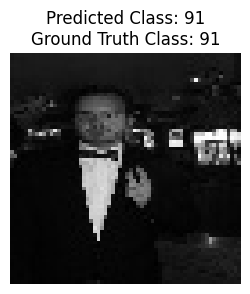

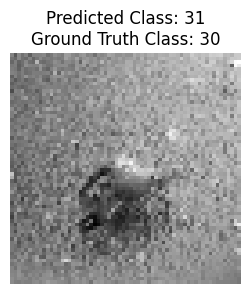

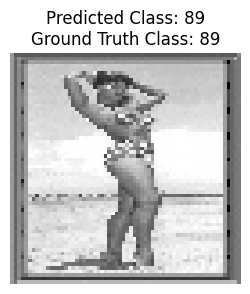

In [ ]:
import random

class_names = [str(i) for i in range(100)] # Define the class names
# Set the model in evaluation mode
vgg.eval() # Set the model in evaluation mode

for _ in range(3): # 3 images
    random_index = random.randint(0, len(val_ds) - 1) # Select a random image from the validation set
    image, label = val_ds[random_index] # Get the image and label
    image = image.to(device)    # Move the image to the GPU, if available
  
    with torch.no_grad():     # Make a prediction on the image
        output = vgg(image.unsqueeze(0)) # Forward pass
        predicted_class = torch.argmax(output).item() # Get the predicted class

    predicted_label = class_names[predicted_class] # Get the predicted class label and the real class label
    real_label = class_names[label] # Get the real class label
    image_np = image.cpu().numpy() # Convert the image tensor to numpy array and normalise the values
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min()) # Normalise the image

    # Plot the image with the predicted class and real class
    plt.figure(figsize = (3, 3)) # Set the figure size
    plt.imshow(image_np.squeeze(), cmap = 'gray') # Plot the gray image
    plt.title(f'Predicted Class: {predicted_label}\nGround Truth Class: {real_label}') # Set the title
    plt.axis('off') # Turn off the axis
    plt.show() # Show the figure

# **TASK 4**

> Choose to cast the problem as supervised or self-supervised learning task

done up in task 3, we used the supervised approach

# **TASK 5**

> Model Evaluation: evaluate the performance of the models using metrics such as accuracy,
precision, recall, and F1-score.

done up in task 3, we measured the train and validation accuracy and loss

# **TASK 6**

> Hyperparameter Tuning: fine-tune the hyperparameters of the models to achieve better
performance.

### Using a scheduler with vgg

In [ ]:
from sklearn.metrics import f1_score
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

Epoch 1/20
Training Loss: 4.0604 | Training Accuracy: 0.0709
Validation Loss: 3.3366 | Validation Accuracy: 0.1749



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 2/20
Training Loss: 3.0225 | Training Accuracy: 0.2397
Validation Loss: 2.6618 | Validation Accuracy: 0.3189

Epoch 3/20
Training Loss: 2.4896 | Training Accuracy: 0.3635
Validation Loss: 2.3875 | Validation Accuracy: 0.3944

Epoch 4/20
Training Loss: 2.1306 | Training Accuracy: 0.4518
Validation Loss: 2.0616 | Validation Accuracy: 0.4720

Epoch 5/20
Training Loss: 1.8592 | Training Accuracy: 0.5185
Validation Loss: 1.8907 | Validation Accuracy: 0.5168

Epoch 6/20
Training Loss: 1.6369 | Training Accuracy: 0.5738
Validation Loss: 1.8656 | Validation Accuracy: 0.5289

Epoch 7/20
Training Loss: 1.4697 | Training Accuracy: 0.6173
Validation Loss: 1.6954 | Validation Accuracy: 0.5679

Epoch 8/20
Training Loss: 1.3224 | Training Accuracy: 0.6542
Validation Loss: 1.5579 | Validation Accuracy: 0.6040

Epoch 9/20
Training Loss: 1.2070 | Training Accuracy: 0.6866
Validation Loss: 1.5117 | Validation Accuracy: 0.6201

Epoch 10/20
Training Loss: 1.1084 | Training Accuracy: 0.7131
Validation

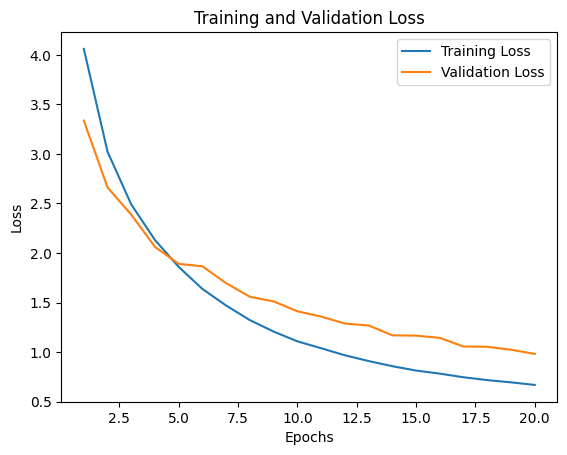

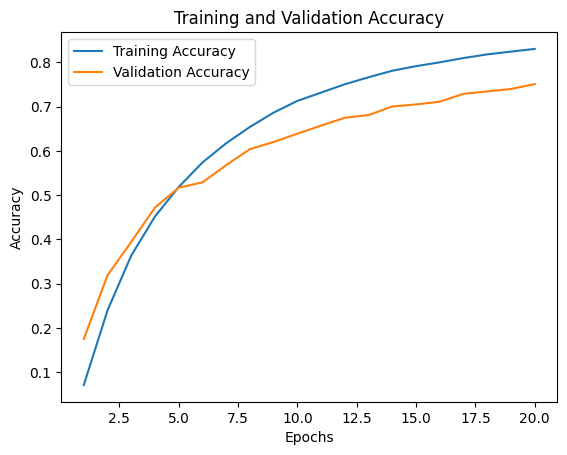

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import random
## fine tuning with vgg16
# Load the VGG16 model
vgg = models.vgg16(pretrained=True)
vgg.features[0] = torch.nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
num_classes = 100
vgg.classifier[-1] = nn.Sequential(
    # nn.Dropout(0.5),  # Add dropout layer with 0.5 dropout rate
    nn.Linear(vgg.classifier[-1].in_features, 512),
    nn.GELU(),
    nn.Linear(512, 256),
    nn.GELU(),
    nn.Linear(256, num_classes)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg = vgg.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(), lr=0.0001)

# Learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


# Training history
train_losses = []
train_accuracies = []

# Validation history
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 20 # Define the number of epochs

for epoch in range(num_epochs): # For each epoch
    vgg.train()  # Set the model in training mode
    running_loss = 0.0 # Set the running loss
    correct = 0 # Set the correct
    total = 0 # Set the total

    for images, labels in train_dl: # For each batch
        images = images.to(device) # Move the image
        labels = labels.to(device) # Move the label

        optimizer.zero_grad()  # Zero the gradients
        outputs = vgg(images)  # Forward pass

        loss = criterion(outputs, labels.squeeze())  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        running_loss += loss.item() # Add the loss
        _, predicted = outputs.max(1) # Get the predicted label
        total += labels.size(0) # Get the total
        correct += predicted.eq(labels.squeeze()).sum().item() # Get the correct

    train_loss = running_loss / len(train_dl) # Compute the training loss
    train_accuracy = correct / total # Compute the training accuracy

    # Validation loop
    vgg.eval()  # Set the model in evaluation mode
    val_loss = 0.0 # Set the validation loss
    correct = 0 # Set the correct
    total = 0 # Set the total

    with torch.no_grad(): # Do not track the gradients
        for images, labels in val_dl: # For each batch
            images = images.to(device) # Move the image
            labels = labels.to(device) # Move the label

            outputs = vgg(images) # Forward pass
            loss = criterion(outputs, labels.squeeze()) # Compute the loss

            val_loss += loss.item() # Add the loss
            _, predicted = outputs.max(1) # Get the predicted label
            total += labels.size(0) # Get the total
            correct += predicted.eq(labels.squeeze()).sum().item() # Get the correct

    val_loss /= len(val_dl) # Compute the validation loss
    val_accuracy = correct / total # Compute the validation accuracy

    # Store the training and validation metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Update the learning rate
    scheduler.step(val_loss)

    # Print the training and validation loss and accuracy
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")
    print()

# Plotting the training and validation metrics
epochs = range(1, num_epochs + 1)

# Plotting the loss
plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy
plt.figure()
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

### Using a scheduler with resnet

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import random

from scipy.stats import spearmanr, pearsonr
import itertools
from torch.optim.lr_scheduler import CosineAnnealingLR


resnet = models.resnet50(pretrained = True) # Load the ResNet-50 model
resnet.conv1 = torch.nn.Conv2d(1, 64, kernel_size = 7, stride = 2, padding = 3, bias = False) # Modify the first layer to accept single-channel images
num_classes = 100  # Modify the classifier layer to match the number of classes in the dataset
resnet.fc = torch.nn.Linear(2048, num_classes) # Modify the fully connected layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Set the device
resnet = resnet.to(device) # Move the model to the device

criterion = nn.CrossEntropyLoss() # Define the loss function: cross entropy
optimizer = optim.Adam(resnet.parameters(), lr=0.001) # Define the optimizer: adam


# Training loop
num_epochs = 20
patience = 4
best_val_loss = np.inf
early_stopping_counter = 0
scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.05)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
f1_scores = []

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20
Training Loss: 3.8590 | Training Accuracy: 0.1137
Validation Loss: 3.7003 | Validation Accuracy: 0.1486

Epoch 2/20
Training Loss: 3.0635 | Training Accuracy: 0.2467
Validation Loss: 3.4702 | Validation Accuracy: 0.1970

Epoch 3/20
Training Loss: 2.6588 | Training Accuracy: 0.3300
Validation Loss: 2.8125 | Validation Accuracy: 0.3018

Epoch 4/20
Training Loss: 2.3403 | Training Accuracy: 0.3989
Validation Loss: 2.9874 | Validation Accuracy: 0.2905

Epoch 5/20
Training Loss: 2.0598 | Training Accuracy: 0.4626
Validation Loss: 2.3963 | Validation Accuracy: 0.3968

Epoch 6/20
Training Loss: 1.7828 | Training Accuracy: 0.5275
Validation Loss: 2.8983 | Validation Accuracy: 0.3423

Epoch 7/20
Training Loss: 1.5298 | Training Accuracy: 0.5895
Validation Loss: 1.8085 | Validation Accuracy: 0.5230

Epoch 8/20
Training Loss: 1.2947 | Training Accuracy: 0.6494
Validation Loss: 1.7093 | Validation Accuracy: 0.5519

Epoch 9/20
Training Loss: 1.1015 | Training Accuracy: 0.7001
Validation 

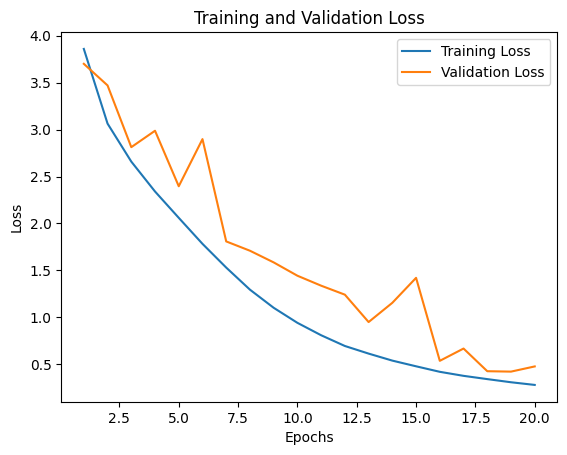

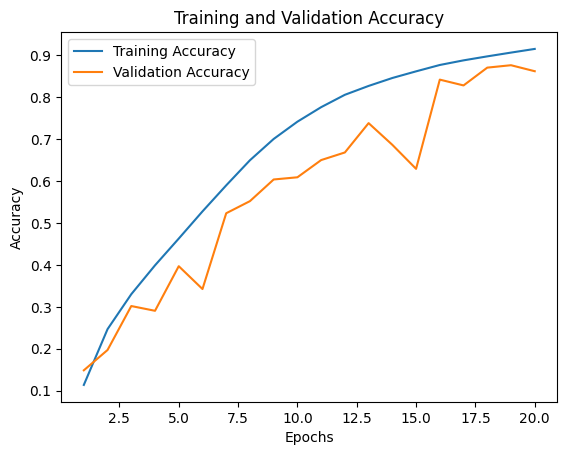

In [ ]:
# Training history
train_losses = []
train_accuracies = []

# Validation history
val_losses = []
val_accuracies = []

# Training loop
num_epochs = 20 # Define the number of epochs

for epoch in range(num_epochs): # For each epoch
    resnet.train()  # Set the model in training mode
    running_loss = 0.0 # Set the running loss
    correct = 0 # Set the correct
    total = 0 # Set the total

    for images, labels in train_dl: # For each batch
        images = images.to(device) # Move the image
        labels = labels.to(device) # Move the label

        optimizer.zero_grad()  # Zero the gradients
        outputs = resnet(images)  # Forward pass

        loss = criterion(outputs, labels.squeeze())  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        running_loss += loss.item() # Add the loss
        _, predicted = outputs.max(1) # Get the predicted label
        total += labels.size(0) # Get the total
        correct += predicted.eq(labels.squeeze()).sum().item() # Get the correct

    train_loss = running_loss / len(train_dl) # Compute the training loss
    train_accuracy = correct / total # Compute the training accuracy

    # Validation loop
    resnet.eval()  # Set the model in evaluation mode
    val_loss = 0.0 # Set the validation loss
    correct = 0 # Set the correct
    total = 0 # Set the total

    with torch.no_grad(): # Do not track the gradients
        for images, labels in val_dl: # For each batch
            images = images.to(device) # Move the image
            labels = labels.to(device) # Move the label

            outputs = resnet(images) # Forward pass
            loss = criterion(outputs, labels.squeeze()) # Compute the loss

            val_loss += loss.item() # Add the loss
            _, predicted = outputs.max(1) # Get the predicted label
            total += labels.size(0) # Get the total
            correct += predicted.eq(labels.squeeze()).sum().item() # Get the correct

    val_loss /= len(val_dl) # Compute the validation loss
    val_accuracy = correct / total # Compute the validation accuracy

    # Store the training and validation metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print the training and validation loss and accuracy
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Training Loss: {train_loss:.4f} | Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")
    print()
    # Update the learning rate
    scheduler.step(val_loss)

# Plotting the training and validation metrics
epochs = range(1, num_epochs + 1)

# Plotting the loss
plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting the accuracy
plt.figure()
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()